## Pricing proposal
The goal of the company is to maximize the profit of the business over the 12 months. Since the price for each ride is fixed $30, in this proposal, I’m going to decide the cost of platform, that is how much we should pay each driver.

To simplify the problems, I make the following assumptions.
<li>1. Assume there's no other competitor platform in the market, so that we don't need to consider competition in our pricing strategy  </li>
<li>2. Factors that influence the number of riding requests based solely on number of match in the previous months</li>
<li>3. Factors that influence the drivers whether accept the requests solely based on price </li>
<li>4. Each month we have 1000 riders, some of them are previous old riders who might request more than 1 ride based on lambda, some of them are new riders who only request 1 ride. </li>
<li>5. DriverAcceptanceData distribution is the same for each month</li>
<li>6. Match rate for each month equals to the accepting rate in DriverAcceptanceData distribution </li>

The followings would be steps how I analyze this problems

<li>Explore and analyze the driverAcceptanceData data, including distribution, price accepted range </li>
<li>Explore the profit based on different pay rate to drivers </li>
<li>Explore the profit changed if new users acquired per month</li>

Conclusion:

I found that when no newly users added and if the pay rate to driver is $25/trip, the total profit for all 12 months can be the max, however, since the low price charge from rider and high acquisition cost, the max profit is still negative.  


In [124]:
"""
import the csv file and 
"""
import pandas as pd
df = pd.read_csv('driverAcceptanceData.csv') 
df = df.iloc[:,1:]
df.head(3)

,PAY,ACCEPTED
0,29.358732,0
1,22.986847,0
2,18.020348,0


<h3> Explore and analyze the driverAcceptanceData data </h3>

The x-axis is the price pay to driver, y-axis is the accept count associated with x price.

total accept count: 527
accept rate for price below 30: 0.211


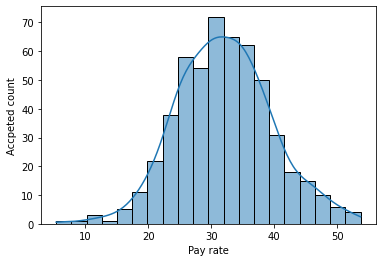

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
acceptdf = df[df.ACCEPTED==1] 
ax = sns.histplot(data=acceptdf, x="PAY", kde=True)
ax.set(xlabel = "Pay rate", ylabel = 'Accpeted count')

# accepted rate for pay <= 30
acceptBelow30 = 1.0*( len(acceptdf[acceptdf.PAY <= 30])/ len(df))
print('total accept count:', len(acceptdf))
print('accept rate for price below 30:', acceptBelow30)


According to the graph, it shows that the distribution almost follows a gaussian distribution. Among all the accepted rides, 40% of them has price below $30. 

In [137]:
rejectdf = df[df.ACCEPTED==0]
accept10 = len(acceptdf[(acceptdf.PAY<=10)])
 
accept20 = len(acceptdf[(acceptdf.PAY >10) & (acceptdf.PAY<=20)])
accept30 = len(acceptdf[(acceptdf.PAY >20) & (acceptdf.PAY<=30)])
accept40 = len(acceptdf[(acceptdf.PAY >30) & (acceptdf.PAY<=40)])
accept50 = len(acceptdf[(acceptdf.PAY >40) & (acceptdf.PAY<=50)])
accept60 = len(acceptdf[(acceptdf.PAY >50)])

rejectdf10 = len(rejectdf[(rejectdf.PAY<=10)])
rejectdf20 = len(rejectdf[(rejectdf.PAY >10) & (rejectdf.PAY<=20)])
rejectdf30 = len(rejectdf[(rejectdf.PAY >20) & (rejectdf.PAY<=30)])
rejectdf40 = len(rejectdf[(rejectdf.PAY >30) & (rejectdf.PAY<=40)])
rejectdf50 = len(rejectdf[(rejectdf.PAY >40) & (rejectdf.PAY<=50)])
rejectdf60 = len(rejectdf[(rejectdf.PAY >50)])

matchrate10 = 1.0*accept10/(accept10+ rejectdf10)  
matchrate20 = 1.0*accept20/(accept20+ rejectdf20)  
matchrate30 = 1.0*accept30/(accept30+ rejectdf30)  
matchrate40 = 1.0*accept40/(accept40+ rejectdf40)  
matchrate50 = 1.0*accept50/(accept50+ rejectdf50)  
matchrate60 = 1.0*accept60/(accept60+ rejectdf60) 

data = [['<=10', accept10,rejectdf10,matchrate10],['10<x<=20', accept20,rejectdf20,matchrate20],['20<x<=30',accept30,rejectdf30,matchrate30],['30<x<=40',accept40,rejectdf40,matchrate40],['40<x<=50',accept50,rejectdf50,matchrate50],['50<x<=60',accept60,rejectdf60,matchrate60]]
matchratedf = pd.DataFrame(data, columns=['range','accpetcount', 'rejectcount', 'acceptrate'])
  
# print dataframe.
matchratedf                                                                                                                                            

,range,accpetcount,rejectcount,acceptrate
0,<=10,2,59,0.032787
1,10<x<=20,21,195,0.097222
2,20<x<=30,188,188,0.500000
3,30<x<=40,242,29,0.892989
4,40<x<=50,65,2,0.970149
5,50<x<=60,9,0,1.000000


After we dividing the pay range into several interval, we found that range[40,50] and [50,60] has highest match rate

In [40]:
minaccept = min(acceptdf.PAY)
maxaccept = max(acceptdf.PAY)
print("accepted price range is [", minaccept,', ',maxaccept,']' )

price range accepted is [ 5.403973164 ,  53.66756318 ]


<h3>Explore the impact of pay rate on the number of match rides over 12 months</h3>

In [19]:
from scipy.stats import poisson

First of all, we need to find the break even point that revenue = cost
<li> Revenue = 30 * match ride </li> 
<li> Cost = Rider Acquired cost + Driver cost = Number of New rider * 30 + match ride * cost/ride </li> 
<br>
In this model, for each month, I divide riders into 2 groups. One is old riders, who take ride in the previous months. The other is new riders, who are newly acquired in this month.

parameter for the model includes: number of new riders acquired for each month, cost pay to driver
 

In [233]:
"""
driverPay is a dictionary 
key is the cost and rate is the match rate based on the driverAcceptanceData 
"""
driverPay = {}
driverPay[10] = 0.03
driverPay[15] = 0.10
driverPay[25] = 0.5
driverPay[35] = 0.9
driverPay[45] = 0.97
driverPay[55] = 1

payToDriver ={}
for i in range(1,13):
    payToDriver[i] = 25
    
    

def getDetails(nextlambdas, monthid, payToDriver,num_new_riders, riderMatchBefore, res):
    
    if monthid ==13:
        return
    if monthid == 1: # in the first month
        newrider = 1000
        oldrider = 0
        lambdas = 1
    else:
        oldrider = riderMatchBefore
        newrider = num_new_riders
    lambdas = nextlambdas
    peopleHasRequest = oldrider  * (1- poisson.cdf(k=0, mu=lambdas)) + newrider* (1- poisson.cdf(k=0, mu=1))
    requestNo = oldrider*lambdas + newrider*1
    peopleNoRequest = 1000 - peopleHasRequest
    matchrate = driverPay[payToDriver[monthid]]
    matchNo = requestNo*matchrate
    peopleNoMatch = peopleHasRequest*(1-matchrate)
    peoplehasMatch = peopleHasRequest* matchrate 
    riderLeave = int(peopleNoRequest + peopleNoMatch)
    
    income = matchNo *30
    cost = matchNo * payToDriver[monthid]
    acquirecost = newrider*30
    totalcost = cost + acquirecost
    profit = income - cost -acquirecost
    nextlambdas =  matchNo/peoplehasMatch
    res.append([monthid, income, totalcost, profit, int(oldrider), int(newrider), riderLeave, lambdas])
    getDetails(nextlambdas, monthid+1, payToDriver, num_new_riders, peoplehasMatch, res)
    return res

res = getDetails(1,1, payToDriver, 0, 0, [])
details = pd.DataFrame(res, columns=['month','income', 'totalcost', 'profit', 'old_Rider', 'new_Rider', 'riderLeave', 'lambdas'])
print("total profit:", details.profit.sum())
details 


total profit: -25001.220703125


,month,income,totalcost,profit,old_Rider,new_Rider,riderLeave,lambdas
0,1,15000.000000,42500.000000,-27500.000000,0,1000,683,1.000000
1,2,7500.000000,6250.000000,1250.000000,316,0,874,1.581977
2,3,3750.000000,3125.000000,625.000000,125,0,945,1.991331
3,4,1875.000000,1562.500000,312.500000,54,0,975,2.306152
4,5,937.500000,781.250000,156.250000,24,0,988,2.561378
5,6,468.750000,390.625000,78.125000,11,0,994,2.775654
6,7,234.375000,195.312500,39.062500,5,0,997,2.960094
7,8,117.187500,97.656250,19.531250,2,0,998,3.121849
8,9,58.593750,48.828125,9.765625,1,0,999,3.265791
9,10,29.296875,24.414062,4.882812,0,0,999,3.395382


plot graph, x-axis is the cost pay to driver, y-axis is the profit. Assume each month we pay the same price to driver

          profit  payrate
0  -29381.443299       10
1  -28333.333333       15
2  -25001.220703       25
3  -62290.670858       35
4 -178486.454917       45
5 -330000.000000       55


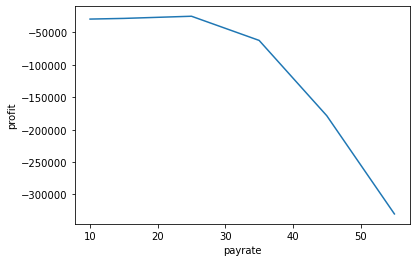

In [240]:
profits = []
for k in driverPay.keys():
    payToDriver ={} 
    res = []

    for i in range(1,13):
        payToDriver[i] = k
    res = getDetails(1,1, payToDriver,0, 0, [])
    details = pd.DataFrame(res, columns=['month','income', 'totalcost', 'profit', 'old_Rider', 'new_Rider', 'riderLeave', 'lambdas'])
    profits.append([details.profit.sum(),k])

profit_payrate = pd.DataFrame(profits, columns=['profit','payrate'])
sns.lineplot(data=profit_payrate , x="payrate", y="profit")
print(profit_payrate )

From above graph, we noticed that if no new riders added in the subsequent months and assume the payrate is fixed, the max profit will be negative when payrate is $25.

